# General Stuff

For this preliminary look, we consider a two-dimensional rocket. It is assumed that the rocket is axisymmetric (so that the pitch and yaw moments of inertia are equal) and that the principal axes of inertia are aligned with the obvious axes of the rocket. Since this is a preliminary sizing analysis, we assume that pitch and yaw control are the drivers for servo sizing - roll control will almost certainly require less control effort. (This assumption may be worth revisiting.)

For this analysis, we use right-handed coordinates, and say that the $+z$ axis points "upwards" along the long axis of the rocket (with $z = 0$ as the base of the rocket).

We care about the angular velocity, pitch angle, horizontal velocity and horizontal position. The state of the rocket can thus be represented as a vector $[s_x, v_x, \theta_y, \omega_y]^T \in \mathbb{R}^4$, where $s_x$ is the horizontal position, $v_x$ is the horizontal velocity, $\theta_y$ is the rotation of the rocket about the global $y$ axis, and $\omega_y$ is the angular speed about the y axis (i.e. the rate of change of $\theta_y$). Ideally we want the control system to drive these errors to zero, though we care more about $\theta_y$ than $x$ and $v_x$. 

I am not very good at aerodynamics (or maths generally), so please let me know about any obvious errors I've made in this analysis. (Even if they don't significantly change the results of this rough-order-of-magnitude analysis, they'll likely want to be corrected for later analysis in aid of an actual design.)

Following the aerodynamic treatment given in [Niskanen (2013)](http://www.printedrockets.com/uploads/6/9/7/9/6979786/openrocket_techdoc.pdf), and including the effects of a horizontal wind blowing in the $+x$ direction, the rocket's state evolves according to the following set of ODEs:

$\dot{s_x} = v_x$

$\dot{v_x} = \dfrac{T}{m}\sin(\theta_y) - \dfrac{1}{2}C_D A_{ref} \rho v_x^2$

$\dot{\theta_y} = \omega_y$

$\dot{\omega_y} = \dfrac{1}{I_{yy}}\dfrac{A_{ref}\rho v^2}{2}\sin(\alpha)\left(-C_{N_\alpha F}(z_{CG}-z_{CPF})-\sin(\alpha)C_{N_\alpha B}(z_{CG}-z_{CPB})-C_{N_\alpha N}(z_{CG}-z_{CPN})\right)-\dfrac{uz_{CG}}{I_{yy}}$ 

where:

* $T$ is the rocket's thrust and $m$ is the rocket's mass
* $I_{yy}$ is the moment of inertia about the y axis
* $A_{ref}$ is the cross-sectional area of the rocket
* $\rho$, $v$, and $alpha$ are the air density, airspeed and angle of attack respectively (where, if $v_{wind}$ is the horizontal wind speed and $v_z$ is the rocket's vertical speed, then $\alpha = \theta_y - atan\left(\dfrac{v_z}{v_{wind}}\right)$
* $C_{N_\alpha F}$, $C_{N_\alpha B}$ and $C_{N_\alpha N}$ are the normal force coefficients divided by angle of attack of the fins, body and nosecone respectively, with $z_{CPF}$, $z_{CPB}$ and $z_{CPN}$ being the locations of centres of pressure of fins, body and nosecone respectively and $z_{CG}$ the location of centre of mass. Note that I'm butchering the notation somewhat: since $C_{N_\alpha B}$ varies with the angle of attack (Niskanen states that body lift is a second-order effect), this actually denotes the $C_{N_\alpha}$ value divided by $\sin(\alpha)$ at some known $\alpha$.
* $u$ denotes a lateral control force applied at the base of the rocket in the $+x$-direction.

Linearising this about zero, and assuming zero wind, we can write the system in the LTI form $\dot{x} = Ax + Bu$, where:

$A = \begin{bmatrix} 0 & 1 & 0 & 0 \\ 0 & 0 & \frac{T}{m} & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & k & 0 \end{bmatrix}$

$B = \begin{bmatrix} 0 \\ 0 \\ 0 \\ \frac{z_{CG}}{I_{yy}} \end{bmatrix}$

where $k = \dfrac{1}{I_{yy}}\dfrac{A_{ref}\rho v^2}{2}\left(-C_{N_\alpha F}(z_{CG}-z_{CPF})-C_{N_\alpha B}(z_{CG}-z_{CPB})-C_{N_\alpha N}(z_{CG}-z_{CPN})\right)$

Note that the rocket's speed has been left in the matrix $A$ - we'll want to examine the required control system gains at different speeds. (For a fin-steered rocket, the control force provided by a fin at a given angle will scale with $v^{2}$, so there may be some cancellation there,  but I'm doing this part of the analysis in as general a way as possible so the code can be recycled for rockets using some flavour of TVC for active stabilisation.)

<span style="color:red">**todo:** the translational effects of forces have been neglected. Do we care about that?</span>

Without a control force, it is clear (from the bottom-right corner of $A$) that this is simply a second-order system with a couple of integrators stuck on top. From this fact, it is clear to see that $k<0$ will result in a system which is stable in $\theta_y$ - a condition equivalent to the usual "centre of pressure behind centre of gravity" criterion. However, this system is not strictly speaking stable, but rather neutrally stable: if we find the poles of the system (or the eigenvalues of $A$, which is in this case equivalent), we find that their real parts are all zero. For the two poles on the real axis, this is because we have not included any damping terms in the aerodynamic model - i.e. the matching pair $\pm\sqrt{-2}$ might be something more like $-0.1\pm\sqrt{-2}$ in the real world, corresponding to a damped oscillation rather than an undamped one. The other two poles at the origin correspond to the pair of integrators for horizontal velocity and displacement, which allow errors to accumulate. (Note, of course, that the non-linear dynamical system is stable in velocity due to the drag term, but nothing will stop errors in horizontal position from accumulating.)

In [2]:
import numpy as np

A = np.array([[0,1,0,0],[0,0,20,0],[0,0,0,1],[0,0,-2,0]])
B = np.array([[0],[0],[0],[5.0]])

print(np.linalg.eigvals(A))

[ 0.+0.j          0.+0.j          0.+1.41421356j  0.-1.41421356j]


To make this more concrete, let's use some values from an OpenRocket model. As this just a preliminary sizing for a rocket with a relatively poor mass fraction, we'll model the thrust and mass of the rocket as constant, and examine the gains at $v_z = 100\  \text{ms}^{-1}$.

In [3]:
m = 1.468
T = 80.0
T_duration = 4.37
I_yy = 0.315
rho_air = 1.225
z_CG = 0.583
z_CPN = 1.301
z_CPF = 0.04
z_CBP = 0.596
C_NaN = 2.0
C_NaF = 4.08 #4.08 is stable (~1 cal), 2.64 is just barely unstable, 2.65 is just barely unstable, 0.5 is badly unstable
C_NaB = 1.86/np.sin(np.deg2rad(5))
A_ref = 48.7/10000

vz_nom = 100.0

k = (1/I_yy)*(A_ref*rho_air*vz_nom**2)/2*(-C_NaF*(z_CG-z_CPF)-C_NaN*(z_CG-z_CPN))
A = np.array([[0,1,0,0],[0,0,T/m,0],[0,0,0,1],[0,0,k,0]])
B = np.array([[0],[0],[0],[z_CG/I_yy]])

print(np.linalg.eigvals(A))

[ 0.+0.j          0.+0.j          0.+8.59119536j  0.-8.59119536j]


In [4]:
import scipy.signal as sig
import scipy.linalg as sclalg

def lqr(A,B,Q,R):
    """Solve the continuous time lqr controller. Code stolen from www.mwm.im/lqr-controllers-with-python/
     
    dx/dt = A x + B u
     
    cost = integral x.T*Q*x + u.T*R*u
    """
    #ref Bertsekas, p.151
 
    #first, try to solve the ricatti equation
    X = np.matrix(sclalg.solve_continuous_are(A, B, Q, R))
     
    #compute the LQR gain
    K = np.matrix(sclalg.inv(R)*(B.T*X))
     
    eigVals, eigVecs = sclalg.eig(A-B*K)
     
    return K, X, eigVals

Qtest = np.diag([0.01,0.5,10000.0,50.0])
Rtest = np.matrix([[0.5]])

K,X,eigVals = lqr(A,B,Qtest,Rtest)
print("K = ", K)
print("Computed eigvals = ", eigVals)

K =  [[   0.14142136    1.3417024   114.2901182    14.95004687]]
Computed eigvals =  [-13.58849699+9.34092227j -13.58849699-9.34092227j  -0.33661014+0.j
  -0.15584770+0.j        ]


Populating the interactive namespace from numpy and matplotlib


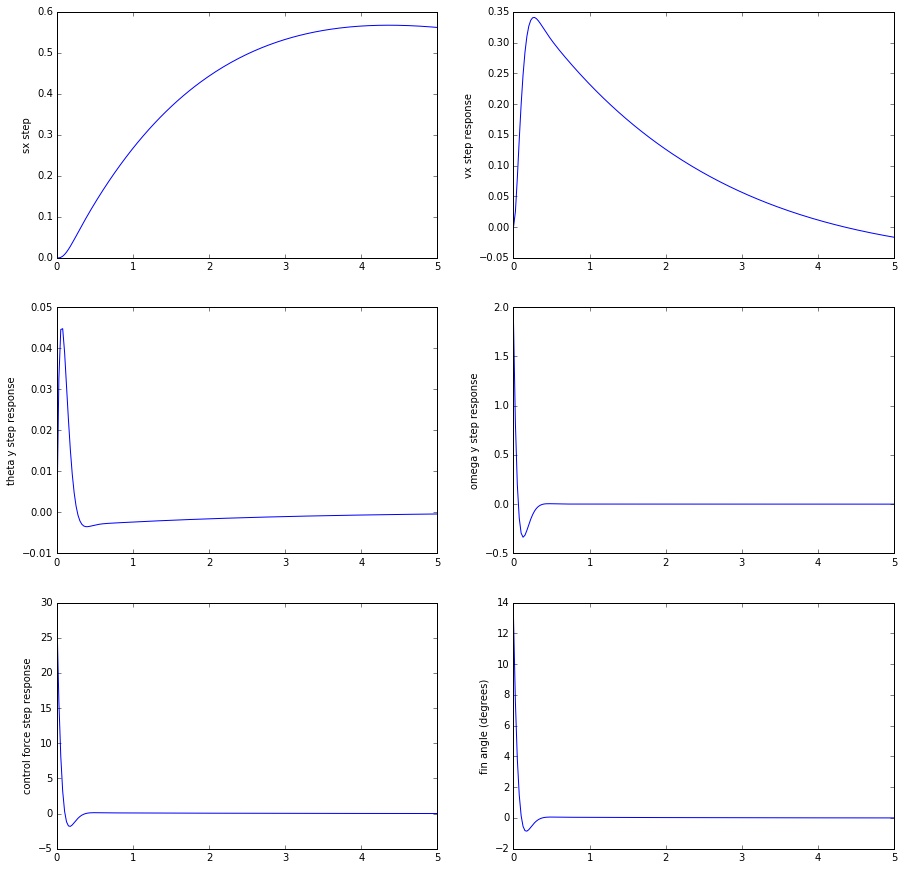

In [5]:
%pylab inline

C = np.vstack([np.eye(4), np.zeros(4)])
D = np.array([[0],[0],[0],[0],[1.0]])

cl_sys = sig.lti(A-B*K,B,C,D)

Tstep, Ystep = sig.impulse(cl_sys, T=np.linspace(0,5,200))

figsize(15,15)
fig=plt.figure()

sp1=fig.add_subplot(321)
sp1.plot(Tstep,Ystep[:,0])
sp1.set_ylabel("sx step")

sp2=fig.add_subplot(322)
sp2.plot(Tstep,Ystep[:,1])
sp2.set_ylabel("vx step response")

sp3=fig.add_subplot(323)
sp3.plot(Tstep,Ystep[:,2])
sp3.set_ylabel("theta y step response")

sp4=fig.add_subplot(324)
sp4.plot(Tstep,Ystep[:,3])
sp4.set_ylabel("omega y step response")

uresp = np.zeros_like(Tstep)
fin_angle = np.zeros_like(Tstep)
for ii,T in enumerate(Tstep):
    uresp[ii] = np.dot(K,Ystep[ii,0:4])[0]
    fin_angle[ii] = uresp[ii]/(0.5*C_NaF*rho_air*vz_nom**2*A_ref)
    
sp5 = fig.add_subplot(325)
sp5.plot(Tstep,uresp)
sp5.set_ylabel("control force step response")

sp6 = fig.add_subplot(326)
sp6.plot(Tstep,np.rad2deg(fin_angle))
sp6.set_ylabel("fin angle (degrees)")

# Fin-Specific Stuff

From messing around with different $v_z$ values, it appears that the method above should give a gain matrix $K$ which works reasonably well for all vertical speeds. However, at lower speeds the fins will not be able to provide enough force to respond as quickly as desired - it clearly does not make physical sense to drive a fin to an angle of attack of 1000°, and in fact we would likely want to limit fin angles to perhaps ±10° to avoid flow separation and a subsequent loss of lift - so we'll want to do a full nonlinear simulation to ensure that this control saturation only leads to a slower response rather than a loss of stability.

For servo specifications, we also want to examine the sensitivity of the system to the servo slew rate. (This is especially important given that we might want to gear the servo down somewhat, to avoid magnifying small errors in servo position when only using a small part of its rotational range. At least, that's what someone on the Internet said; not sure how much of an issue it is in practice.)

Servo holding torque is another useful spec. If the fin rotates about an axis which passes through the centre of pressure of the fin, then in principle the required holding torque should be zero. For sizing purposes, however, it may be more useful to get a deliberately-too-high upper bound: for instance, by assuming that the distance between the rotational axis and fin centre of pressure is equal to half the length of the fin's root chord. 

## Servo model

The servo will be modelled as a linear motor: that is, given the stall torque $\tau_s$ and the no-load angular speed $\omega_n$, the torque in the positive direction available at angular velocity $\omega$ is given by:

$\tau_f = \tau_s\dfrac{\omega_n-\omega}{\omega_n}$

and the torque in the negative direction is given by:

$\tau_r = \tau_s\dfrac{\omega_n-\omega}{\omega_n}$

Within the deadband, no voltage is applied to the motor, so the back emf of the motor results in the servo decelerating at a rate proportional to the rotational speed:

$\tau = \tau_s\dfrac{-\omega}{\omega_n}$

The internal control law assumed for the servo model will be a "bang-bang" control law with a deadband: if the servo position is too far from the commanded position, then the motor will drive it in the appropriate direction at maximum torque. This model may lead to some overshoot after reaching the correct position, and it's possible that typical servos will be more intelligent than this, but this again gives us a worst-case scenario.

Simulating... done.


F:\Miniconda3\lib\site-packages\scipy\integrate\_ode.py:869: UserWarning: vode: Repeated error test failures. (Check all input.)
  'Unexpected istate=%s' % istate))


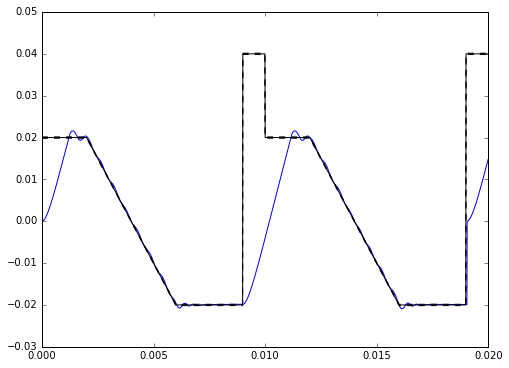

In [6]:
from scipy.integrate import ode

I_f =  1900.0/1e9 # from rough CAD model, assuming rotation about fin centre of mass. originally in g/mm²
om_n = 2*np.pi/(6*0.05) # servo rotational speed typically specified as e.g. "0.05 sec per 60 degrees"
tau_s = 6.5*9.81*0.01 # servo torque typically given in kgf.cm, want to convert to Nm

back_torque_per_radian = 0.0 # tau_s/0.08 # torque pushing servo back towards zero, to represent restoring force on fins

# hobby servo deadband typically given in μs, relative to the 1 ms pulse width range of the incoming PWM signal.
# 1 ms corresponds to the full rotational range of pi radians.
deadband_radius = 1.0/(1000*2*np.pi) 

om_0 = om_n/2

#some example position commands.
def position_command(t):
    cyclet = t%0.01
    
    if cyclet < 0.002:
        return 0.02
    elif cyclet <0.006:
        return 0.02-10*(cyclet-0.002)
    elif cyclet <0.009:
        return -0.02
    else:
        return 0.04

def motor_state_dot(t,state, servo_commanded_pos=0.0, tau_s = tau_s, om_n = om_n):
    statedot = np.zeros_like(state)
    
    statedot[0] = state[1]
    
    om = state[1]    
    
    available_torque_forward = tau_s*(om_n-om)/om_n
    available_torque_reverse = tau_s*(-om_n-om)/om_n
    self_braking_torque = -tau_s*om/om_n
    
    if (state[0] - servo_commanded_pos) > deadband_radius:
        statedot[1] = available_torque_reverse/I_f
    elif (state[0] - servo_commanded_pos) < -deadband_radius:
        statedot[1] = available_torque_forward/I_f
    else:
        statedot[1] = self_braking_torque/I_f
    
    statedot[1] -= state[0]*back_torque_per_radian/I_f
    
    return statedot, np.array([available_torque_forward, available_torque_reverse])

num_points = 2000
time_res = 1e-5

state0 = np.array([0.0, 0.0])
t0 = 0

r = ode(motor_state_dot)

r.set_initial_value(state0,t0)

times = np.zeros(num_points)
derivHist = np.zeros((2,num_points))
stateHist = np.zeros((2,num_points))

extraHist = np.zeros((2,num_points))
deadbandHist = np.zeros((2,num_points))

stateHist[:,0] = state0
derivHist[:,0], extraHist[:, 0] = motor_state_dot(t0, state0)

deadbandHist[0,0] = position_command(t0)+deadband_radius
deadbandHist[1,0] = position_command(t0)-deadband_radius

print('Simulating... ', end='')

for ii in range (1,num_points):
    t = ii*time_res
    
    r.set_f_params(position_command(t), tau_s/4)
    
    r.integrate(t)
    
    stateHist[:, ii] = r.y
    times[ii] = t
    derivHist[:, ii], extraHist[:, ii] = motor_state_dot(t,r.y)
    
    deadbandHist[0,ii] = position_command(t)+deadband_radius
    deadbandHist[1,ii] = position_command(t)-deadband_radius
      
print('done.')

figsize(8,6)

plt.plot(times, stateHist[0,:])
plt.plot(times, deadbandHist[0,:], 'k--')
plt.plot(times, 0.5*(deadbandHist[0,:]+deadbandHist[1,:]), 'k')
plt.plot(times, deadbandHist[1,:], 'k--')

Simulating... done.


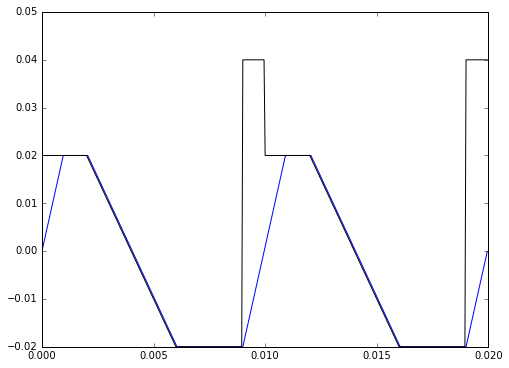

In [7]:
class SimplifiedServo:
    max_speed = 1.0
    target_pos = 0
    start_pos = 0
    t_start = 0
    
    def __init__(self, max_speed):
        self.max_speed = max_speed
        
    def set_positions(self, start_pos, target_pos, t_start):
        self.target_pos = target_pos
        self.start_pos = start_pos
        self.t_start = t_start
        
    def get_position(self, t):
        total_pos_delta = self.target_pos - self.start_pos
        
        pos_delta_at_t = np.sign(total_pos_delta)*min(abs(total_pos_delta), (t-self.t_start)*self.max_speed) 
        
        return self.start_pos+pos_delta_at_t

testServo = SimplifiedServo(om_n)
testServo.set_positions(0.0, 0.0, 0.0)

num_points = 400
time_res = 5e-5

t0 = 0

times = np.zeros(num_points)
stateHist = np.zeros(num_points)
targetHist = np.zeros(num_points)

targetHist[0] = position_command(t0)

print('Simulating... ', end='')

for i in range (1,num_points):
    testServo.set_positions(stateHist[i-1], position_command(t), times[i-1])
    
    t = i*time_res
    times[i] = t
    
    stateHist[i] = testServo.get_position(t)
    targetHist[i] = position_command(t)
      
print('done.')

figsize(8,6)

plt.plot(times, stateHist)
plt.plot(times, targetHist, 'k')

## Nonlinear model with LQR feedback

Now, we just need to implement the set of nonlinear ODEs from the first section. [and model other effects, eventually]

In [8]:
def thrustcurve(t):
    if t>0.0 and t<4.4:
        return 80.0
    else:
        return 0.0

def masscurve(t):
    if t<=0.0:
        return 1.468
    elif t>4.4:
        return 1.249
    else:
        return 1.468- t/4.4*(1.468-1.249)

def rho_air(alt):
    return 1.225*np.exp(-alt/7200)

def wind_profile(alt):
    if (alt > 50.0) and (alt < 100.0):
        return 3.0
    else:
        return 20.0
    
C_D = 0.51
g0 = 9.81

state0 = np.zeros(6)
state0[4] = 0.0
t0 = 0
num_points = 15000
time_res = 1e-3

control_system_timestep_count = 10 # 100 Hz (inc both PWM delay and avionics lag)

rail_length = 4.0

# state: sx, sz, vx, vz, theta, om_y. servo is set up as a different thing.
def rocket_state_dot(t, state, control_system_active, servo_model):
    statedot = np.zeros_like(state)
    statedot[0] = state[2]
    statedot[1] = state[3]
    
    statedot[2] = thrustcurve(t)/masscurve(t)*np.sin(state[4])-0.5*C_D*A_ref*rho_air(state[1])*state[2]*abs(state[2])
    statedot[3] = thrustcurve(t)/masscurve(t)*np.cos(state[4])-0.5*C_D*A_ref*rho_air(state[1])*state[3]*abs(state[3])-g0

    statedot[4] = state[5]
        
    alpha = state[4]-np.arctan2(state[2]+wind_profile(state[1]), state[3])
    v_air = ((state[2]-wind_profile(state[1]))**2+state[3]**2)**0.5    
        
    if control_system_active:
        fin_alpha = alpha + servo_model.get_position(t)
    else:
        fin_alpha = alpha #state[6]
    
    body_torque = -C_NaN*(z_CG-z_CPN)-np.sin(alpha)*C_NaB*(z_CG-z_CBP)
    fin_torque  = -C_NaF*(z_CG-z_CPF)
    
    if state[1] < rail_length:
        statedot[5] = 0.0
    else:
        statedot[5] = body_torque*np.sin(alpha)+fin_torque*np.sin(fin_alpha)
        statedot[5] *= 1/I_yy*(A_ref*rho_air(state[1])*v_air**2)/2
    
    extra = np.array([alpha, fin_alpha]) #, commanded_force])
    
    return statedot, extra

fin_servo = SimplifiedServo(om_n)

def rocket_flight_sim(control_system_active = True):
    rocket_flight = ode(rocket_state_dot)
    rocket_flight.set_initial_value(state0, t0)
    rocket_flight.set_f_params(control_system_active, fin_servo)

    times = np.zeros(num_points)
    stateHist = np.zeros([state0.size,num_points])
    derivHist = np.zeros_like(stateHist)
    extraHist = np.zeros([3,num_points])

    stateHist[:,0] = state0
    derivHist[:,0], extraHist[0:2,0] = rocket_state_dot(t0, state0, control_system_active, fin_servo)

    print('Simulating... ')

    for ii in range (1,num_points):
        t = ii*time_res

        rocket_flight.integrate(t)
        
        if ((ii % control_system_timestep_count) == 0):
            input_state = stateHist[:, ii-control_system_timestep_count]
            commanded_force = input_state[0]*K[0,0]+input_state[2]*K[0,1]+input_state[4]*K[0,2]+input_state[5]*K[0,3]
            v_air = ((input_state[2]-wind_profile(input_state[1]))**2+input_state[3]**2)**0.5
            
            commanded_fin_angle = commanded_force/(0.5*C_NaF*rho_air(input_state[1])*v_air**2*A_ref)
            
            fin_servo.set_positions(fin_servo.get_position(t), commanded_fin_angle, t)
            
            rocket_flight.set_f_params(control_system_active, fin_servo)
    
        stateHist[:, ii] = rocket_flight.y
        times[ii] = t
        derivHist[:, ii], extraHist[0:2, ii] = rocket_state_dot(t, rocket_flight.y, control_system_active, fin_servo)
        
        extraHist[2, ii] = fin_servo.get_position(t)
        
        if ((ii % 10000) == 0):
            print('.', end='')
          
    print('done.')
    
    return times, stateHist, derivHist, extraHist

times, stateHist, derivHist, extraHist = rocket_flight_sim()
times, stateHist2, derivHist2, extraHist2 = rocket_flight_sim(control_system_active=False)

figsize(15,10)

Simulating... 
.done.
Simulating... 
.done.


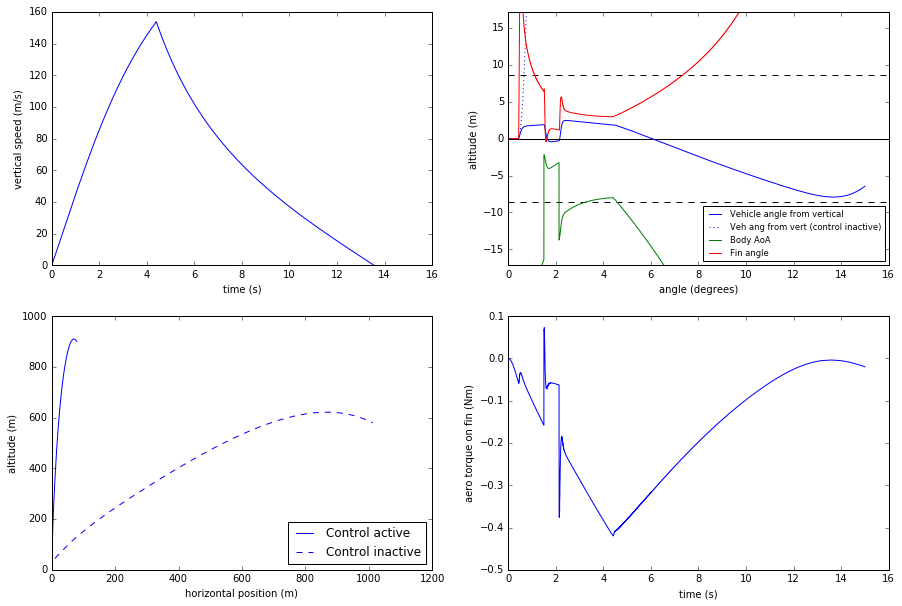

In [9]:
fig=plt.figure()

sp1=fig.add_subplot(221)
sp1.plot(times, stateHist[3,:])
sp1.set_ylim(0, 160)
sp1.set_xlabel("time (s)")
sp1.set_ylabel("vertical speed (m/s)")

sp2=fig.add_subplot(222)
sp2.axhline(np.rad2deg(0.15), color='k', linestyle='--')
sp2.axhline(np.rad2deg(0.0), color='k', linestyle='-')
sp2.axhline(np.rad2deg(-0.15), color='k', linestyle='--')
sp2.plot(times, np.rad2deg(stateHist[4,:]), label="Vehicle angle from vertical")
sp2.plot(times, np.rad2deg(stateHist2[4,:]), 'b:', label="Veh ang from vert (control inactive)")
sp2.plot(times, np.rad2deg(extraHist[0,:]), label="Body AoA")
sp2.plot(times, np.rad2deg(extraHist[2,:]), label="Fin angle")
sp2.set_ylim(np.rad2deg(-0.3), np.rad2deg(0.3))
sp2.set_xlabel("angle (degrees)")
sp2.set_ylabel("altitude (m)")
sp2.legend(loc=4, fontsize='small')

sp3=fig.add_subplot(223)
plt.plot(stateHist[0,:], stateHist[1,:], label="Control active")
plt.plot(stateHist2[0,:], stateHist2[1,:], 'b--', label="Control inactive")
sp3.set_xlabel("horizontal position (m)")
sp3.set_ylabel("altitude (m)")
sp3.legend(loc=4)

sp4 = fig.add_subplot(224)
plt.plot(times, 0.035*0.5*C_NaF*np.sin(extraHist[1,:])*A_ref*0.5*rho_air(stateHist[1,:])*(stateHist[3,:]**2+stateHist[2,:]**2))
sp4.set_ylabel("aero torque on fin (Nm)")
sp4.set_xlabel("time (s)")